In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 4.1 선형회귀

### 4.1.1 정규방정식
-> 비용 함수를 최소화하는 θ값을 찾기 위한 해석적인 방법
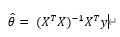
#### 정규 방정식을 사용한 선형 회귀

In [3]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

(0.0, 2.0, 0.0, 15.0)

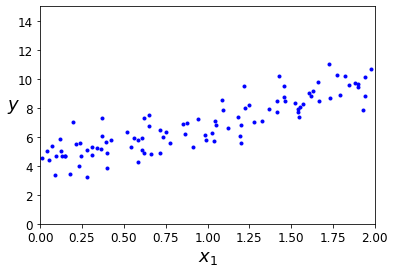

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

In [5]:
X_b = np.c_[np.ones((100, 1)), X]  # https://rfriend.tistory.com/352
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  #inv: 역행렬 함수

In [6]:
theta_best   #θ0 = 4.17, θ1 = 2.94

array([[4.21509616],
       [2.77011339]])

θ ̂을 사용해 y 예측

In [7]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] #왜 1을 추가하지?
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

In [8]:
print(X_new_b)
print(X_new)

[[1. 0.]
 [1. 2.]]
[[0]
 [2]]


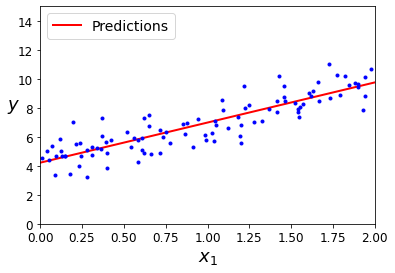

In [9]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형회귀 수행

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_   #편향(bias), 가중치(weight)

(array([4.21509616]), array([[2.77011339]]))

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

LinearRegression 클래스는 scipy.linalg.lstsq()를 기반으로 함. 이 함수 직접 호출 가능


θ ̂= X^+ y 계산
-> X^+는 X의 유사 역행렬(np.linalg.pinv()함수를 사용해 직접 구할 수 있음)

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [13]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 4.2 경사 하강법
### 4.1 배치 경사 하강법

In [14]:
eta = 0.1 #학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #랜덤 초기화   -> w, b

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients   

In [15]:
theta

array([[4.21509616],
       [2.77011339]])

In [16]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [17]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
            
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

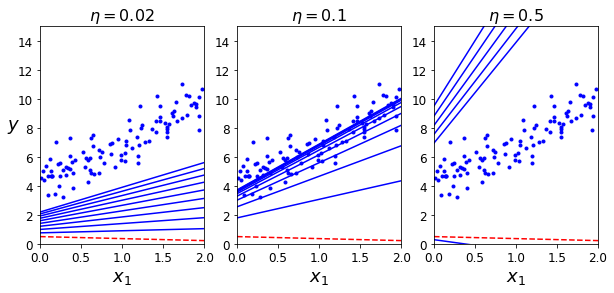

In [18]:
np.random.seed(42)
theta = np.random.randn(2,1)  

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

### 4.2 확률적 경사 하강법

In [19]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

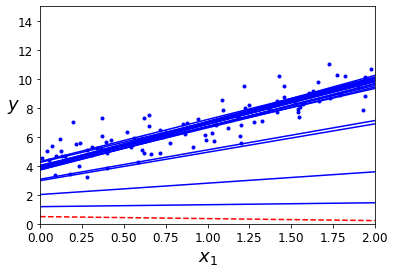

In [20]:
n_epochs = 50
t0, t1 = 5, 50   #학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

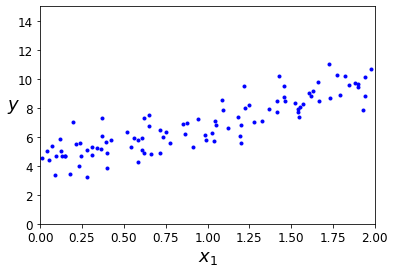

In [21]:
n_epochs = 50
t0, t1 = 5, 50   #학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
       
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [22]:
theta

array([[4.18545376],
       [2.77900595]])

In [23]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
#최대 1000번 에포크 동안 실행, 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행, 학습률 0.1로 기본 학습 스케쥴 사용
sgd_reg.fit(X, y.ravel())  #y.ravel() y를 1차원으로 바꿈

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법

In [25]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0 
for epoch in range(n_iterations):
    
    shuffled_indices = np.random.permutation(m) #무작위 배열 생성
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [26]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [27]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

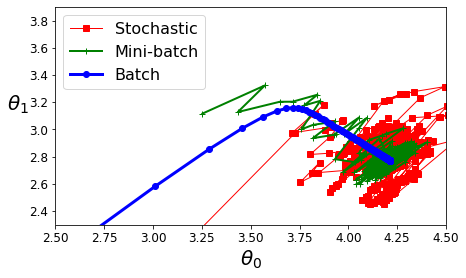

In [28]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## 4.3 다항 회귀

In [29]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [30]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

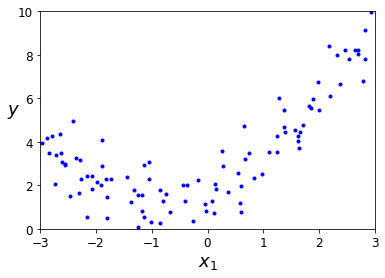

In [31]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [32]:
#훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [33]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

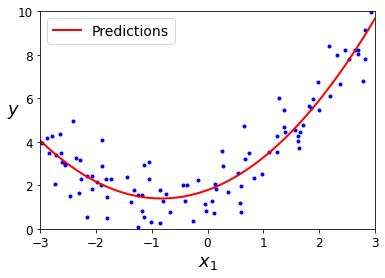

In [35]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])

plt.show()

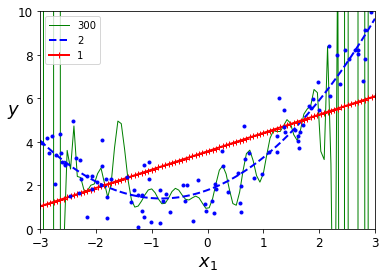

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

## 4.4 학습 곡선

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

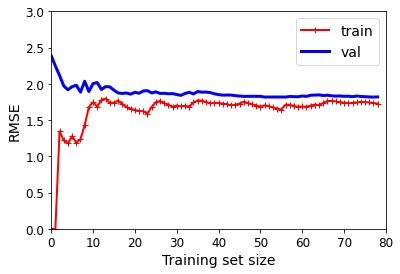

In [37]:
#과소적합의 전형적인 모습
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

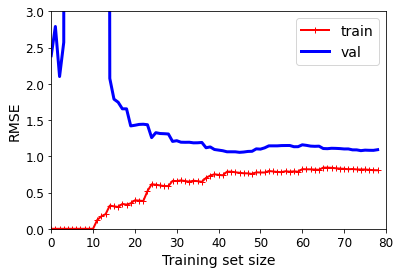

In [38]:
#10차 다항회귀

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

## 4.5 규제가 있는 선형 모델
### 4.5.1 릿지 회귀
-> 규제가 추가된 선형 회귀 버전

-> 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 함

-> 훈련하는 동안에만 비용 함수에 추가(성능은 규제가 없는 성능 지표로 평가)

In [43]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

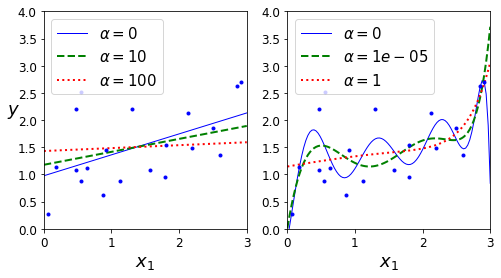

In [44]:
#PolynomialFeatures(degree=10)으로 데이터 확장 후 StandardScaler사용하여 스케일 조정
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
            
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
   
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [47]:
#사이킷런에서 정규방정식을 사용한 릿지 회귀
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [52]:
#확률적 경사하강법 사용
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
#penaly="l2"-> 릿지 회귀와 동일한 규제 추가
sgd_reg.fit(X, y.ravel()) #y.ravel() y를 1차원으로 바꿈
sgd_reg.predict([[1.5]])

array([1.47012588])

### 4.5.2 라쏘 회귀
-> 라쏘 회귀의 특징: 덜 중요한 특성의 가중치를 제거(0으로 만듦)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8028677038274514, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


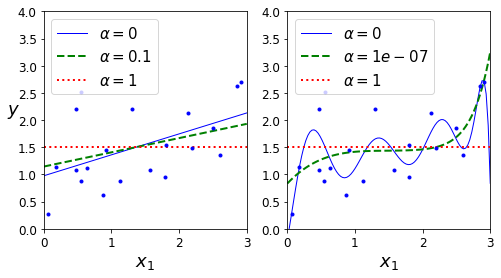

In [53]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

### 4.5.3 엘라스틱넷
-> 릿지 회귀와 라쏘 회귀를 절충한 모델

In [54]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 조기 종료
-> 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 방식

In [55]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [58]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)
#warm_start=True -> fit()메서드가 호추로딜때 이전 모델 파라미터에서 훈련 이어감

minimum_val_error = float("inf")
best_epoch=None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

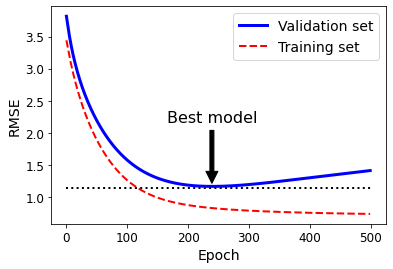

In [65]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs=500
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

#주석
plt.annotate('Best model',
            xy=(best_epoch, best_val_rmse),
            xytext=(best_epoch, best_val_rmse+1),
            ha="center",
            arrowprops=dict(facecolor="black", shrink=0.05),
            fontsize=16,)

best_val_rmse -= 0.03 
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [66]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

## 4.6 로지스틱 회귀
### 4.6.1 확률 추정


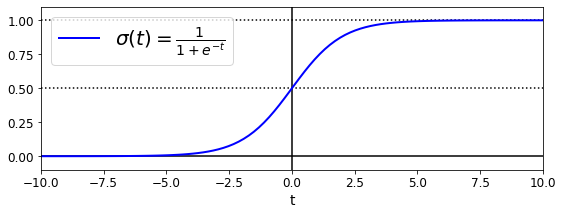

In [67]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

plt.show()

### 4.6.2 훈련과 비용 함수
### 4.6.3 결정 경계
Iris-Versicolor종을 감지하는 분류기

In [68]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [70]:
X = iris["data"][:, 3:] #꽃잎의 너비
y = (iris["target"]==2).astype(np.int)  # Iris virginica이면 1 아니면 0

<ipython-input-70-d4c7498794bb>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"]==2).astype(np.int)  # Iris virginica이면 1 아니면 0


In [71]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X,y)

LogisticRegression(random_state=42)

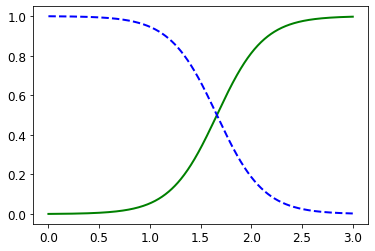

In [76]:
#꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

C:\Users\user\anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


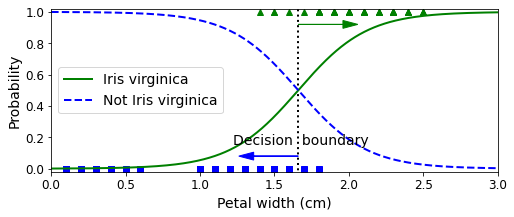

In [78]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

In [79]:
decision_boundary

array([1.66066066])

In [90]:
X_new[y_proba[:, 1] >= 0.5][0] #0.5가 처음 넘는 x값

array([1.66066066])

In [91]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

<ipython-input-92-baee5c15f7b2>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


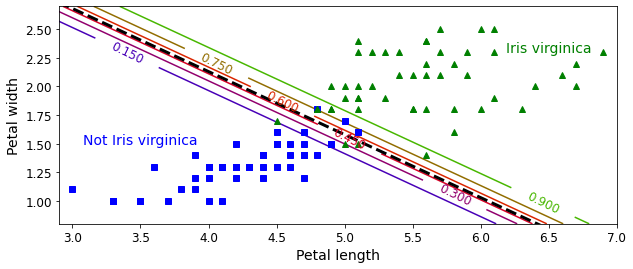

In [92]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

### 4.6.4 소프트맥스 회귀

In [94]:
X = iris["data"][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [97]:
softmax_reg.predict([[1, 2]])

array([0])

In [99]:
softmax_reg.predict_proba([[1, 2]])

array([[9.99488934e-01, 5.11065839e-04, 3.26936830e-10]])

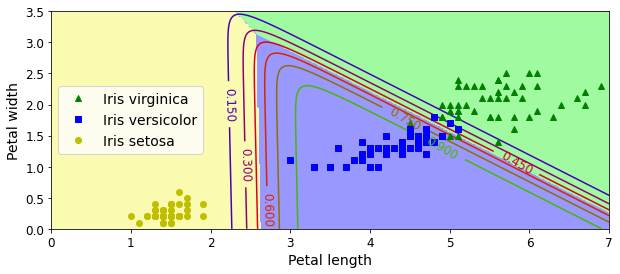

In [105]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1,1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new) #분류 결과가 아닌 해당 레이블로 분류될 확률값 반환
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()

In [106]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
x0

array([[2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ],
       [2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ],
       [2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ],
       ...,
       [2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ],
       [2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ],
       [2.9       , 2.90821643, 2.91643287, ..., 6.98356713, 6.99178357,
        7.        ]])

In [108]:
np.ones((100, 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],